In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.insert(0, "../src")

<IPython.core.display.Javascript object>

In [72]:
import gc
import math
from argparse import ArgumentParser
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from sklearn import metrics
from sklearn import model_selection
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl

from utils import *

<IPython.core.display.Javascript object>

In [4]:
torch.backends.cudnn.benchmark = True
print("PyTorch version:", torch.__version__)

PyTorch version: 1.6.0


<IPython.core.display.Javascript object>

# Baseline

## Setup

In [7]:
NUM_FOLDS = 5
# SIZE = 120
# INPUT_SHAPE = (SIZE, SIZE, 4)
# BATCH_SIZE = 256
LR = 1e-3
EPOCHS = 10

<IPython.core.display.Javascript object>

In [8]:
PATH = Path("../input")
TRAIN_PATH = PATH / "train"
TEST_PATH = PATH / "test"
DAMS = (6071, 6304, 7026, 7629, 7767, 8944, 11107)

<IPython.core.display.Javascript object>

## Resize

In [9]:
(PATH / "train-64").mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

In [10]:
def resize_data(fn, dpath=TRAIN_PATH, sz=64):
    data = np.load(fn)
    img1 = cv2.resize(data[:, :, :3], (sz, sz), interpolation=cv2.INTER_AREA)
    img2 = cv2.resize(data[:, :, 2:], (sz, sz), interpolation=cv2.INTER_AREA)
    data = np.concatenate([img1[:, :, :2], img2], axis=-1)
    np.save((fn.parent.parent) / "train-64" / fn.name, data)

<IPython.core.display.Javascript object>

In [37]:
files = list(TRAIN_PATH.iterdir())
with ThreadPoolExecutor(8) as e:
    e.map(resize_data, files)

<IPython.core.display.Javascript object>

## Dataset

In [29]:
TRAIN_PATH = PATH / "train-64"
sz = 64
bs = 256

<IPython.core.display.Javascript object>

In [77]:
df = pd.read_csv(PATH / "train_folds.csv")
df.head()

,filename,fold
0,train_60668.npy,0
1,train_60911.npy,0
2,train_14956.npy,0
3,train_24086.npy,0
4,train_09805.npy,0


<IPython.core.display.Javascript object>

In [ ]:
test_df = pd.read_csv(PATH / "test.csv")

In [30]:
class NowcastDataset(torch.utils.data.Dataset):
    def __init__(self, df, test=False):
        self.filenames = df.filename.values
        self.test = test

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        data = np.load((TEST_PATH if self.test else TRAIN_PATH) / filename)
        img = data[:, :, :4]
        img = torch.tensor(img, dtype=torch.float)
        img = img.permute(2, 0, 1)

        if self.test:
            return img

        sz = img.shape[0]
        target = data[:, :, -1]
        target = torch.tensor(target, dtype=torch.float)
        target = target.unsqueeze(0)

        return img, target

<IPython.core.display.Javascript object>

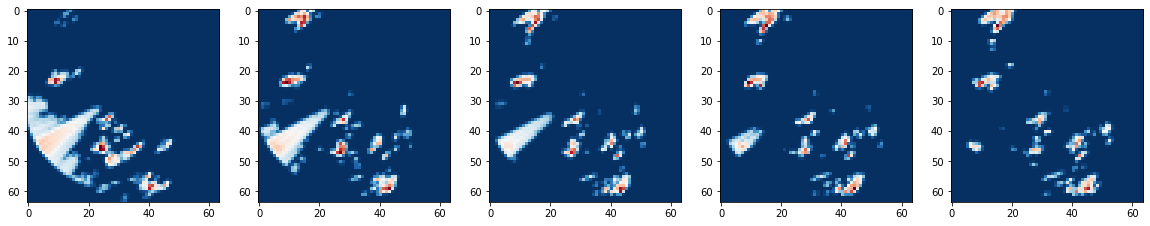

<IPython.core.display.Javascript object>

In [31]:
df = pd.read_csv(PATH / "train_folds.csv")
ds = NowcastDataset(df)
x, y = ds[0]
x = x.permute(1, 2, 0).numpy()
y = y.permute(1, 2, 0).numpy()
img = np.concatenate([x, y], axis=-1)
visualize(img)

In [78]:
class NowcastDataModule(pl.LightningDataModule):
    def __init__(self, df, fold):
        super().__init__()
        self.df = df
        self.fold = fold

    def setup(self, stage="train"):
        if stage == "train":
            train_df = df[df.fold != self.fold]
            valid_df = df[df.fold == self.fold]
            self.train_dataset = NowcastDataset(train_df)
            self.val_dataset = NowcastDataset(valid_df)
        else:
            test_dataset = NowcastDataset(df)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=bs,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset, batch_size=2 * bs, num_workers=4, pin_memory=True
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset, batch_size=2 * bs, num_workers=4, pin_memory=True
        )

<IPython.core.display.Javascript object>

## Model

In [17]:
class DoubleConv(nn.Module):
    """
    Double convolution and ReLU and BN
    (3x3 conv -> ReLU -> BN) ** 2
    """

    def __init__(self, nin, nout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nin, nout, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(nout),
            nn.Conv2d(nout, nout, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(nout),
        )

    def forward(self, x):
        return self.net(x)

<IPython.core.display.Javascript object>

In [16]:
class Down(nn.Module):
    def __init__(self, nin, nout):
        self.net = nn.Sequential(
            DoubleConv(nin, nout),
            nn.MaxPool2d(kernel_size=2),
        )

    def forward(self, x):
        return self.net(x)

<IPython.core.display.Javascript object>

In [60]:
class Up(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(nin, nout, kernel_size=2, stride=2)
        self.conv = DoubleConv(nin, nout)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)

<IPython.core.display.Javascript object>

In [84]:
class Rainnet(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.conv1 = DoubleConv(4, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = DoubleConv(512, 1024)

        self.up6 = Up(1024, 512)
        self.up7 = Up(512, 256)
        self.up8 = Up(256, 128)
        self.up9 = Up(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)

        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)

        conv5 = self.conv5(pool4)
        #         print(conv5.shape)
        up6 = self.up6(conv5, conv4)
        #         print(up6.shape)
        up7 = self.up7(up6, conv3)
        #         print(up7.shape)
        up8 = self.up8(up7, conv2)
        #         print(up8.shape)
        up9 = self.up9(up8, conv1)
        #         print(up9.shape)
        out = self.out(up9)
        out = F.relu(out)
        #         print(out.shape)

        return out

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        return loss

    def shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

<IPython.core.display.Javascript object>

In [85]:
m = Rainnet(lr=LR)

<IPython.core.display.Javascript object>

In [86]:
dm = NowcastDataModule(df, 0)
dm.setup()

<IPython.core.display.Javascript object>

In [89]:
trainer = pl.Trainer(gpus=1, precision=16)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


<IPython.core.display.Javascript object>

In [90]:
trainer.fit(m, dm)


   | Name  | Type       | Params
--------------------------------------
0  | conv1 | DoubleConv | 39 K  
1  | pool1 | MaxPool2d  | 0     
2  | conv2 | DoubleConv | 221 K 
3  | pool2 | MaxPool2d  | 0     
4  | conv3 | DoubleConv | 886 K 
5  | pool3 | MaxPool2d  | 0     
6  | conv4 | DoubleConv | 3 M   
7  | pool4 | MaxPool2d  | 0     
8  | conv5 | DoubleConv | 14 M  
9  | up6   | Up         | 9 M   
10 | up7   | Up         | 2 M   
11 | up8   | Up         | 574 K 
12 | up9   | Up         | 143 K 
13 | out   | Conv2d     | 65    


Epoch 0:  89%|████████▊ | 197/222 [00:55<00:07,  3.56it/s, loss=3.093, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▊ | 197/222 [00:56<00:07,  3.48it/s, loss=2.771, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▊ | 197/222 [00:57<00:07,  3.41it/s, loss=2.917, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▊ | 197/222 [00:58<00:07,  3.36it/s, loss=2.690, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▊ | 197/222 [00:58<00:07,  3.36it/s, loss=2.586, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 5:  15%|█▌        | 34/222 [00:10<00:56,  3.30it/s, loss=2.624, v_num=1] 

/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


Epoch 5:  15%|█▌        | 34/222 [00:10<01:00,  3.11it/s, loss=2.624, v_num=1]


1

Traceback (most recent call last):
  File "/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/isleof/.pyenv/versions/miniconda3-l

<IPython.core.display.Javascript object>